In [1]:
using Pkg
Pkg.activate("../cheb_bessel_tests-main")

  Activating project at `~/Desktop/PhD_Stuff/cheb_bessel_tests-main`


In [2]:
using Plots
using QuadGK
using NPZ
using Interpolations
using DataInterpolations
using LaTeXStrings
using FastChebInterp
using Tullio

[ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
Precompiling IJuliaExt
  ✓ Plots → FileIOExt
  ✓ Plots → UnitfulExt
  ✓ Plots → IJuliaExt
  3 dependencies successfully precompiled in 39 seconds. 190 already precompiled.
[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a]
┌ Warning: Module Plots with build ID fafbfcfd-c766-89c0-0000-01bb7b7cf8ba is missing from the cache.
│ This may mean Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1942
[ Info: Skipping precompilation since __precompile__(false). Importing IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a].
[ Info: Precompiling FileIOExt [f5f51d8f-5827-5d2e-939b-192fcd6ec70c]
┌ Warning: Module Plots with build ID fafbfcfd-c766-89c0-0000-01bb7b7cf8ba is missing from the cache.
│ This may mean Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80] does not support precompilation but is imported by a module that does.
└ @ Base

In [3]:
using Revise
using Blast

[ Info: Precompiling UnitfulExt [0e51ec96-f580-5f12-a625-1297083d7970]
┌ Warning: Module Plots with build ID fafbfcfd-c766-89c0-0000-01bb7b7cf8ba is missing from the cache.
│ This may mean Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1942
[ Info: Skipping precompilation since __precompile__(false). Importing UnitfulExt [0e51ec96-f580-5f12-a625-1297083d7970].


In [4]:
z_W = npzread("data/mynz.npy")["z"]
W = npzread("data/mynz.npy")["nz"];

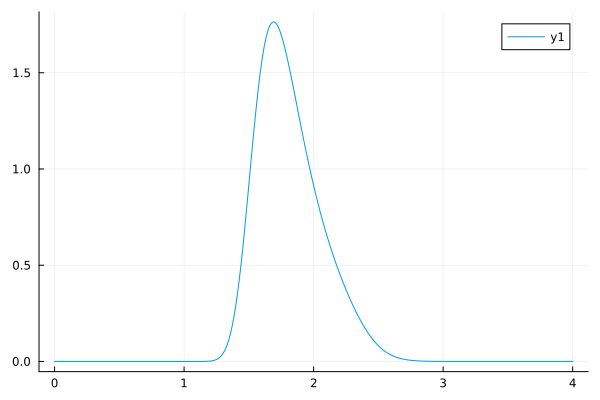

In [5]:
plot(z_W, W)

In [6]:
cosmo = Blast.FlatΛCDM()

Blast.FlatΛCDM{Float64}(-1.0, 0.0, 67.27, 0.3156, 0.0492, 0.6844, 2.12107e-9, 0.816, 0.0, 0.0, 0.9645)

In [7]:
z_range = z_W
grid = Blast.CosmologicalGrid(z_range=z_range)
bg = Blast.BackgroundQuantities(Hz_array = zeros(length(z_range)), χz_array=zeros(length(z_range))); 

In [8]:
#Evaluate background quantities
Blast.evaluate_background_quantities!(grid, bg, cosmo)

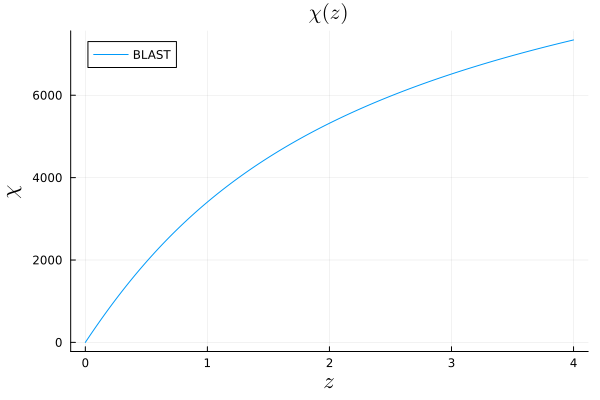

In [9]:
plot(grid.z_range, bg.χz_array, title = L"$\chi(z)$" , xlabel=L"z", ylabel=L"χ", label = "BLAST", labelfontsize=15)

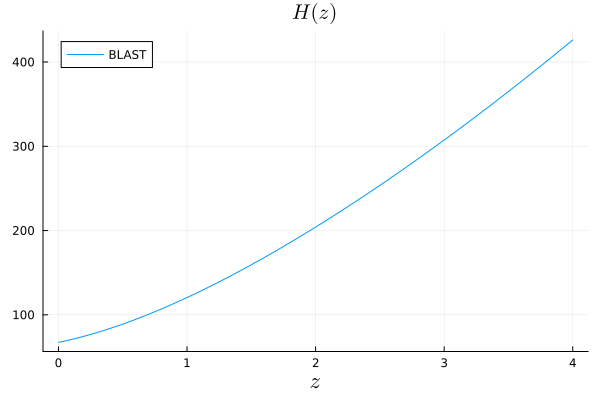

In [10]:
plot(grid.z_range, bg.Hz_array, title = L"$H(z)$" , xlabel=L"z", label = "BLAST", labelfontsize=15)

In [11]:
#Building interpolant z(χ), will be useful later
z_of_χ = DataInterpolations.AkimaInterpolation(grid.z_range, bg.χz_array, extrapolate=true);

In [12]:
T_LL = Blast.T_tilde_p2
T_CL = Blast.T_tilde_0
T_CC = Blast.T_tilde_m2
print("Shape of the precomputed T̃: ", size(T_LL))

Shape of the precomputed T̃: (22, 96, 48, 120)

In [13]:
ℓ = Blast.ℓ
nχ = 96
χ = LinRange(26, 7000, nχ)
R = chebpoints(96, -1, 1)
R = reverse(R[R.>0])
nR = length(R)
kmax = 200/13 
kmin = 2.5/7000
n_cheb = 119
k_cheb = chebpoints(n_cheb, log10(kmin), log10(kmax))
z_cheb = chebpoints(7, 0, 3.5);

In [14]:
z_range = z_of_χ.(χ)
grid = Blast.CosmologicalGrid(z_range=z_range)
bg = Blast.BackgroundQuantities(Hz_array = zeros(length(z_range)), χz_array=zeros(length(z_range)) )
Blast.evaluate_background_quantities!(grid, bg, cosmo)

In [15]:
pk_to_interpolate = npzread("data/camb_pk.npz")["arr_0"]

8×120 Matrix{Float64}:
 0.00675388  0.00678756  0.00688956  …   546.991   544.087   543.122
 0.00729756  0.00733395  0.00744416      591.149   588.011   586.968
 0.00922001  0.00926598  0.00940523      747.317   743.351   742.033
 0.0136463   0.0137143   0.0139204      1106.98   1101.11   1099.15
 0.0233778   0.0234944   0.0238475      1897.96   1887.9    1884.55
 0.0431949   0.0434102   0.0440626   …  3509.04   3490.45   3484.27
 0.0711977   0.0715526   0.0726279      5785.85   5755.2    5745.02
 0.0856041   0.086031    0.0873238      6957.21   6920.36   6908.12

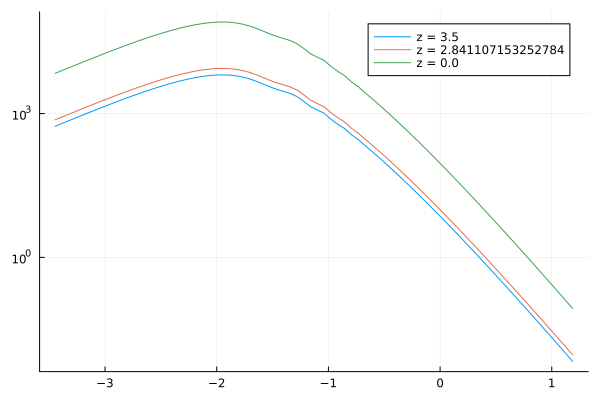

In [16]:
plot(k_cheb, pk_to_interpolate[1,:], yscale=:log10, label="z = $(z_cheb[1])")
plot!(k_cheb, pk_to_interpolate[3,:], yscale=:log10, label="z = $(z_cheb[3])")
plot!(k_cheb, pk_to_interpolate[8,:], yscale=:log10, label="z = $(z_cheb[8])")

In [17]:
plan = Blast.plan_fft(pk_to_interpolate, 1)
pk = Blast.interpolate_power_spectrum(pk_to_interpolate, z_cheb, R, plan, bg, grid);
blast_pk = Blast.unequal_time_power_spectrum(pk);

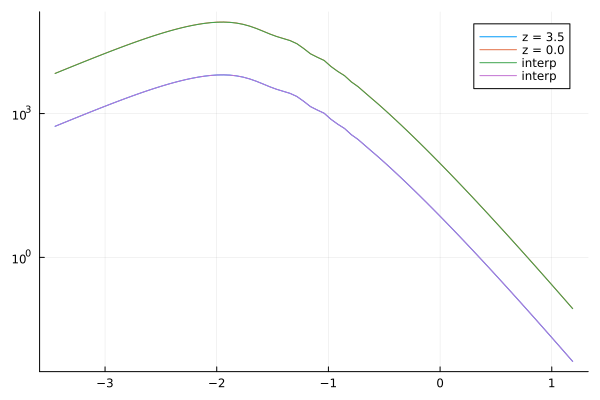

In [18]:
plot(k_cheb, pk_to_interpolate[1,:], yscale=:log10, label="z = $(z_cheb[1])")
plot!(k_cheb, pk_to_interpolate[8,:], yscale=:log10, label="z = $(z_cheb[8])")
plot!(k_cheb, pk[:, 1, end], yscale=:log10, label = "interp")
plot!(k_cheb, pk[:, end, end], yscale=:log10, label = "interp")

## Chebyshev decomposition of the power spectrum

In [19]:
plan = Blast.plan_fft(blast_pk,1) #blast_pk o pk?
cheb_coeff = Blast.fast_chebcoefs(blast_pk, plan); 

In [20]:
w_LL = Blast.w_ell_tullio(permutedims(cheb_coeff, (2,3,1)), T_LL)
w_CL = Blast.w_ell_tullio(permutedims(cheb_coeff, (2,3,1)), T_CL)
w_CC = Blast.w_ell_tullio(permutedims(cheb_coeff, (2,3,1)), T_CC);

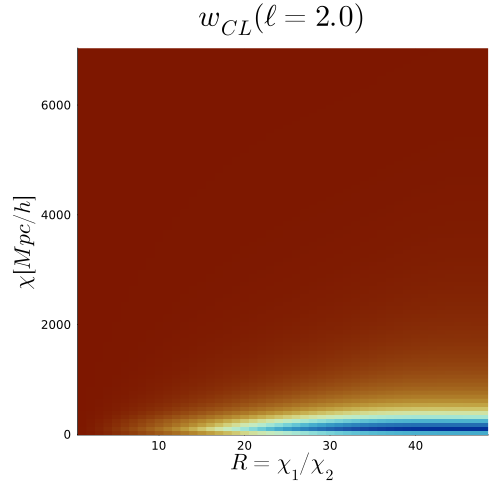

In [25]:
heatmap(1:48, χ, w_CL[1,:,:]./maximum(w_CL[1,:,:]), size = (500,500), title=L"w_{CL}(ℓ=2.0)", 
    c =:roma , xlabel=L"R=\chi_1/\chi_2",ylabel=L"\chi[Mpc/h]", legend=:none,
    yguidefontsize=15, xguidefontsize=15 , titlefontsize=20)

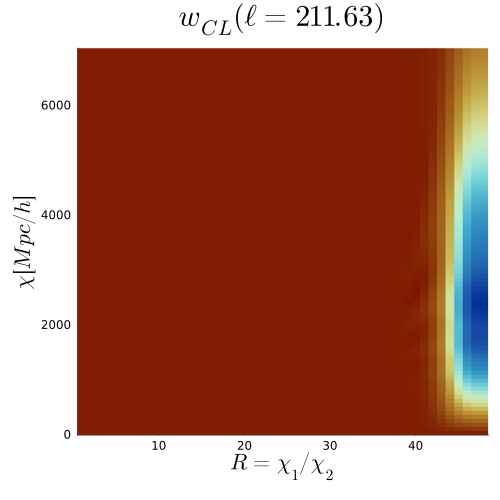

In [26]:
heatmap(1:48, χ, w_CL[22,:,:]./maximum(w_CL[22,:,:]), size = (500,500), title=L"w_{CL}(ℓ=211.63)",
    legend = :none, c =:roma , xlabel=L"R=\chi_1/\chi_2",ylabel=L"\chi[Mpc/h]",
    yguidefontsize=15, xguidefontsize=15 , titlefontsize=20)

In [27]:
#Define the objects
GK = Blast.GalaxyKernel(1, length(grid.z_range))
SHK = Blast.ShearKernel(1, length(grid.z_range))
CMBK = Blast.CMBLensingKernel(length(grid.z_range));

#Compute the kernels - galaxy clustering
Blast.compute_kernel!(reshape(W, 1, length(z_W)), z_W, GK, ones(1),grid, bg, cosmo)
#Compute the kernels - cosmic shear
Blast.compute_kernel!(reshape(W, 1, length(z_W)), z_W, SHK, grid, bg, cosmo)
#Compute the kernels - CMB Lensing
Blast.compute_kernel!(CMBK, grid, bg, cosmo);

In [28]:
GK.Kernel[1,:] = npzread("data/ccl_gal_kernel.npz")["arr_0"]
SHK.Kernel[1,:] = npzread("data/ccl_sh_kernel.npz")["arr_0"]
CMBK.Kernel = npzread("data/ccl_cmb_kernel.npz")["arr_0"];

In [29]:
clustering_Cℓ = Blast.compute_Cℓ(w_CC, GK, GK, bg, R)
shear_Cℓ = Blast.compute_Cℓ(w_LL, SHK, SHK, bg, R)
cross_Cℓ = Blast.compute_Cℓ(w_CL, GK, SHK, bg, R);
cl_cross_cmb_Cℓ = Blast.compute_Cℓ(w_CL, GK, CMBK, bg, R)
sh_cross_cmb_Cℓ = Blast.compute_Cℓ(w_LL, SHK, CMBK, bg, R);

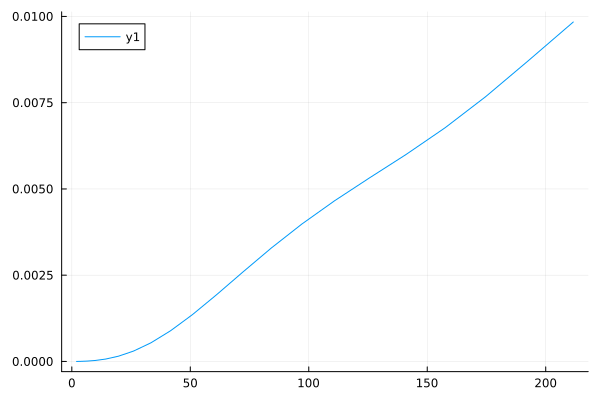

In [30]:
plot(ℓ, ℓ.*(ℓ .+ 1).*clustering_Cℓ[:,1,1])

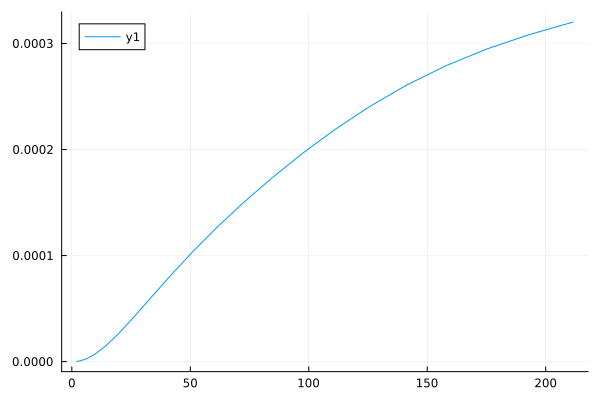

In [27]:
plot(ℓ, ℓ.*(ℓ .+ 1).*shear_Cℓ[:,1,1])

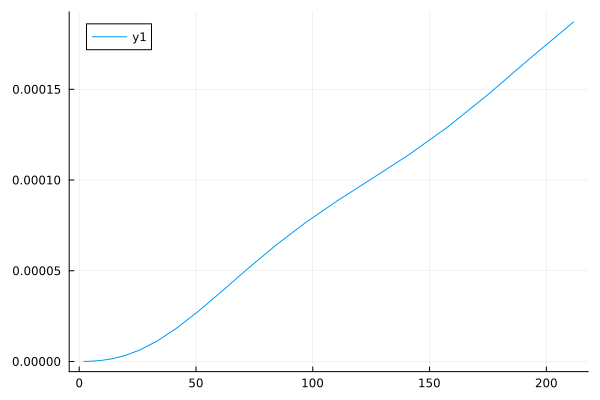

In [28]:
plot(ℓ, ℓ.*(ℓ .+ 1).*cross_Cℓ[:,1,1])

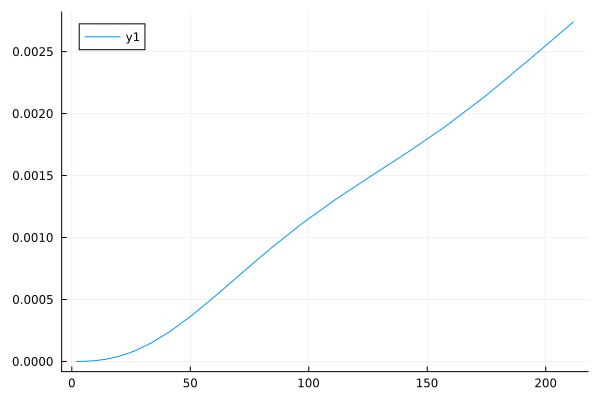

In [29]:
plot(ℓ, ℓ.*(ℓ .+ 1).*cl_cross_cmb_Cℓ[:,1,1])

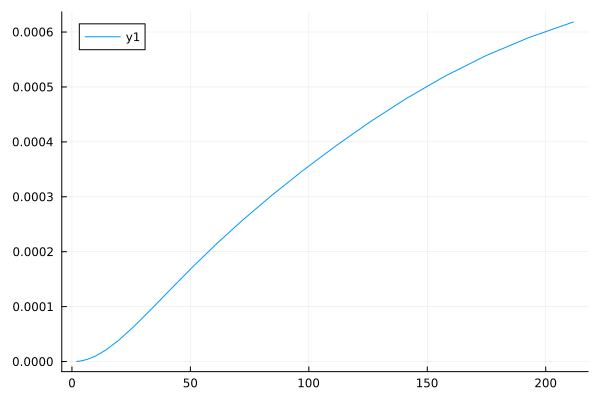

In [30]:
plot(ℓ, ℓ.*(ℓ .+ 1).*sh_cross_cmb_Cℓ[:,1,1])

In [31]:
npzwrite("data/ell_list.npy", ℓ)
npzwrite("blast_cls/blast_gg.npy", ℓ.*(ℓ .+ 1).*clustering_Cℓ[:,1,1])
npzwrite("blast_cls/blast_ss.npy", ℓ.*(ℓ .+ 1).*shear_Cℓ[:,1,1])
npzwrite("blast_cls/blast_gs.npy", ℓ.*(ℓ .+ 1).*cross_Cℓ[:,1,1])
npzwrite("blast_cls/blast_gcmbl.npy", ℓ.*(ℓ .+ 1).*cl_cross_cmb_Cℓ[:,1,1])
npzwrite("blast_cls/blast_scmbl.npy", ℓ.*(ℓ .+ 1).*sh_cross_cmb_Cℓ[:,1,1])

# Non linear contribution

In [90]:
non_lin_pk = npzread("data/camb_lin_pk.npz")["arr_0"]
z_nl = npzread("data/z_nl.npz")["arr_0"]
k_nl = npzread("data/k_nl.npz")["arr_0"];

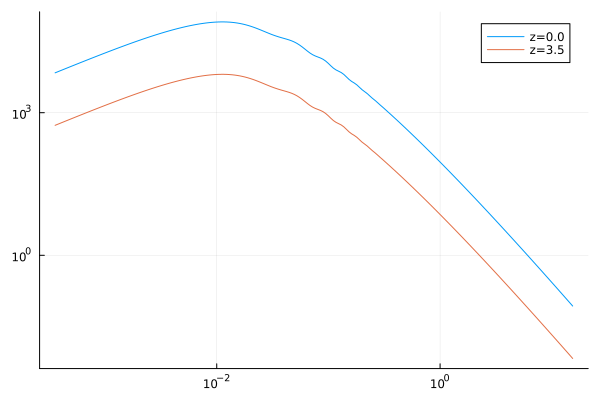

In [91]:
plot(k_nl, non_lin_pk[1,:], yscale=:log10, xscale=:log10,label="z=$(z_nl[1])")
plot!(k_nl, non_lin_pk[end,:], label="z=$(z_nl[end])")

In [92]:
y = LinRange(log10(first(k_nl)),log10(last(k_nl)), length(k_nl))
x = LinRange(first(z_nl), last(z_nl), length(z_nl))
InterpPmm = Interpolations.interpolate(log10.(non_lin_pk),BSpline(Cubic(Line(OnGrid()))))
InterpPmm = scale(InterpPmm, (x, y))
InterpPmm = Interpolations.extrapolate(InterpPmm, Line());

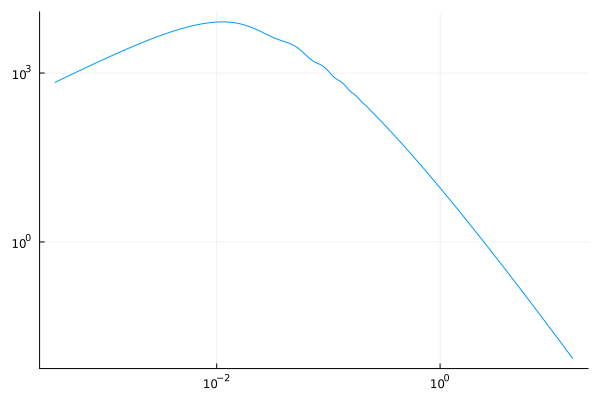

In [93]:
plot(k_nl, 10 .^ InterpPmm(3, log10.(k_nl)), xscale=:log10, yscale=:log10, label=nothing)

In [94]:
function power_spectrum_limber(interp, ℓ::Float64, χ)
    k = (ℓ + 0.5) ./ χ
    return @. 10^interp(z_of_χ(χ),log10(k))
end

power_spectrum_limber (generic function with 2 methods)

In [95]:
function power_spectrum_limber(interp, ℓ::Vector, χ)
    pk_matrix = zeros(length(ℓ), length(χ))
    for (ind, l) in enumerate(ℓ)
        pk_matrix[ind, :] = power_spectrum_limber(interp, l, χ)
    end
    return pk_matrix
end

power_spectrum_limber (generic function with 2 methods)

In [96]:
pk_nl = power_spectrum_limber(InterpPmm, Blast.ℓ, χ) 

22×96 Matrix{Float64}:
 11744.4       53009.0     75403.8     …   587.299   559.181   532.137
  8084.43      44524.9     69891.3         697.104   663.764   631.692
  4135.97      32912.9     50662.3        1018.11    969.596   922.915
  1735.66      17066.7     35057.9        1525.65   1453.46   1383.96
   739.221      9620.48    21966.9        2180.6    2078.42   1979.96
   336.579      5203.11    13476.7     …  2933.19   2797.47   2666.56
   164.894      2894.66     7639.98       3728.01   3558.17   3394.16
    86.4964     1699.07     4767.99       4510.2    4308.47   4113.38
    48.1797     1018.39     3051.33       5230.21   5001.21   4779.36
    28.2634      636.059    1990.09       5846.46   5596.67   5354.21
    17.3351      410.611    1332.02    …  6326.57   6063.79   5808.15
    11.0488      273.129     911.907      6647.99   6380.75   6120.08
     7.28087     186.639     637.232      6798.85   6535.7    6278.25
     4.93967     130.644     454.874      6778.89   6527.72   62

In [97]:
function Cℓ_limber(pk, ℓ, χ, ProbeA::Blast.GalaxyKernel, ProbeB::Blast.GalaxyKernel)
    n = length(χ)
    
    F = ones(length(ℓ))

    Δχ = ((χ[n]-χ[1])/(n-1))
    pesi = Blast.simpson_weight_array(n)

    pk_over_chi = pk ./ (χ .^ 2)'

    KA = ProbeA.Kernel
    KB = ProbeB.Kernel

    @tullio Cℓ[l,i,j] := Δχ*pk_over_chi[l,m]*KA[i,m]*KB[j,m]*pesi[m]*F[l]
    return Cℓ
end

function Cℓ_limber(pk, ℓ, χ, ProbeA::Blast.GalaxyKernel, ProbeB::Blast.ShearKernel)
    n = length(χ)
    
    F = @. sqrt(Blast.factorial_frac(ℓ)) / (ℓ+0.5)^2

    Δχ = ((χ[n]-χ[1])/(n-1))
    pesi = Blast.simpson_weight_array(n)

    pk_over_chi = pk ./ (χ .^ 2)'

    KA = ProbeA.Kernel
    KB = ProbeB.Kernel

    @tullio Cℓ[l,i,j] := Δχ*pk_over_chi[l,m]*KA[i,m]*KB[j,m]*pesi[m]*F[l]
    return Cℓ
end

function Cℓ_limber(pk, ℓ, χ, ProbeA::Blast.ShearKernel, ProbeB::Blast.GalaxyKernel)
    return Cℓ_limber(pk, ℓ, χ, ProbeB, ProbeA)
end

function Cℓ_limber(pk, ℓ, χ, ProbeA::Blast.ShearKernel, ProbeB::Blast.ShearKernel)
    n = length(χ)
    
    F = @. Blast.factorial_frac(ℓ) / (ℓ+0.5)^4

    Δχ = ((χ[n]-χ[1])/(n-1))
    pesi = Blast.simpson_weight_array(n)

    pk_over_chi = pk ./ (χ .^ 2)'

    KA = ProbeA.Kernel
    KB = ProbeB.Kernel

    @tullio Cℓ[l,i,j] := Δχ*pk_over_chi[l,m]*KA[i,m]*KB[j,m]*pesi[m]*F[l]
    return Cℓ
end

function Cℓ_limber(pk, ℓ, χ, ProbeA::Blast.ShearKernel, ProbeB::Blast.CMBLensingKernel)
    n = length(χ)
    
    F = @. sqrt(Blast.factorial_frac(ℓ)) * ℓ * (ℓ + 1) / (ℓ+0.5)^4

    Δχ = ((χ[n]-χ[1])/(n-1))
    pesi = Blast.simpson_weight_array(n)

    pk_over_chi = pk ./ (χ .^ 2)'

    KA = ProbeA.Kernel
    KB = reshape(ProbeB.Kernel, 1, length(χ))

    @tullio Cℓ[l,i,j] := Δχ*pk_over_chi[l,m]*KA[i,m]*KB[j,m]*pesi[m]*F[l]
    return Cℓ
end

function Cℓ_limber(pk, ℓ, χ, ProbeA::Blast.CMBLensingKernel, ProbeB::Blast.ShearKernel)
    return Cℓ_limber(pk, ℓ, χ, ProbeB, ProbeA)
end

function Cℓ_limber(pk, ℓ, χ, ProbeA::Blast.GalaxyKernel, ProbeB::Blast.CMBLensingKernel)
    n = length(χ)
    
    F = @. ℓ * (ℓ + 1) / (ℓ+0.5)^2

    Δχ = ((χ[n]-χ[1])/(n-1))
    pesi = Blast.simpson_weight_array(n)

    pk_over_chi = pk ./ (χ .^ 2)'

    KA = ProbeA.Kernel
    KB = reshape(ProbeB.Kernel, 1, length(χ))

    @tullio Cℓ[l,i,j] := Δχ*pk_over_chi[l,m]*KA[i,m]*KB[j,m]*pesi[m]*F[l]
    return Cℓ
end

function Cℓ_limber(pk, ℓ, χ, ProbeA::Blast.CMBLensingKernel, ProbeB::Blast.GalaxyKernel)
    return Cℓ_limber(pk, ℓ, χ, ProbeB, ProbeA)
end

Cℓ_limber (generic function with 8 methods)

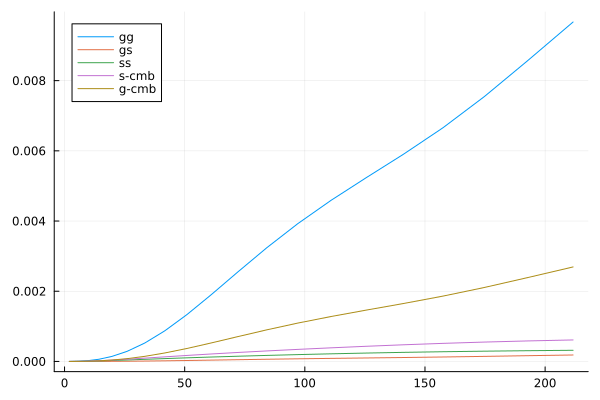

In [98]:
plot(Blast.ℓ, Blast.ℓ .* (Blast.ℓ .+ 1) .* Cℓ_limber(pk_nl, Blast.ℓ, χ, GK, GK)[:,1,1], label = "gg")
plot!(Blast.ℓ, Blast.ℓ .* (Blast.ℓ .+ 1) .* Cℓ_limber(pk_nl, Blast.ℓ, χ, GK, SHK)[:,1,1], label = "gs")
plot!(Blast.ℓ, Blast.ℓ .* (Blast.ℓ .+ 1) .* Cℓ_limber(pk_nl, Blast.ℓ, χ, SHK, SHK)[:,1,1], label = "ss")
plot!(Blast.ℓ, Blast.ℓ .* (Blast.ℓ .+ 1) .* Cℓ_limber(pk_nl, Blast.ℓ, χ, SHK, CMBK)[:,1,1], label = "s-cmb")
plot!(Blast.ℓ, Blast.ℓ .* (Blast.ℓ .+ 1) .* Cℓ_limber(pk_nl, Blast.ℓ, χ, GK, CMBK)[:,1,1], label = "g-cmb")

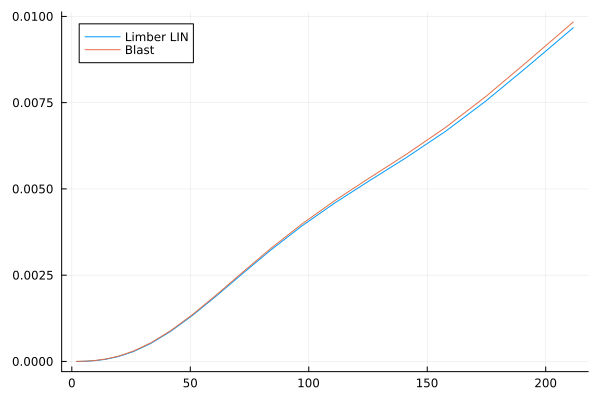

In [99]:
plot(Blast.ℓ, Blast.ℓ .* (Blast.ℓ .+ 1) .* Cℓ_limber(pk_nl, Blast.ℓ, χ, GK, GK)[:,1,1], label = "Limber LIN")
plot!(ℓ, ℓ.*(ℓ .+ 1).*clustering_Cℓ[:,1,1], label = "Blast")


In [100]:
npzwrite("blast_cls/blast_gg_lin.npy", Blast.ℓ .* (Blast.ℓ .+ 1) .* Cℓ_limber(pk_nl, Blast.ℓ, χ, GK, GK)[:,1,1])
npzwrite("blast_cls/blast_ss_lin.npy", Blast.ℓ .* (Blast.ℓ .+ 1) .* Cℓ_limber(pk_nl, Blast.ℓ, χ, GK, SHK)[:,1,1])
npzwrite("blast_cls/blast_gs_lin.npy", Blast.ℓ .* (Blast.ℓ .+ 1) .* Cℓ_limber(pk_nl, Blast.ℓ, χ, SHK, SHK)[:,1,1])
npzwrite("blast_cls/blast_gcmbl_lin.npy", Blast.ℓ .* (Blast.ℓ .+ 1) .* Cℓ_limber(pk_nl, Blast.ℓ, χ, CMBK, SHK)[:,1,1])
npzwrite("blast_cls/blast_scmbl_lin.npy", Blast.ℓ .* (Blast.ℓ .+ 1) .* Cℓ_limber(pk_nl, Blast.ℓ, χ, GK, CMBK)[:,1,1])

# Complete BLAST $C_\ell$

In [101]:
blast_gg = npzread("blast_cls/blast_gg.npy")
blast_ss = npzread("blast_cls/blast_ss.npy")
blast_gs = npzread("blast_cls/blast_gs.npy")
blast_gcmbl = npzread("blast_cls/blast_gcmbl.npy")
blast_scmbl = npzread("blast_cls/blast_scmbl.npy");

In [102]:
nonlin_gg = npzread("blast_cls/blast_gg_nonlin.npy")
nonlin_ss = npzread("blast_cls/blast_ss_nonlin.npy")
nonlin_gs = npzread("blast_cls/blast_gs_nonlin.npy")
nonlin_gcmbl = npzread("blast_cls/blast_gcmbl_nonlin.npy")
nonlin_scmbl = npzread("blast_cls/blast_scmbl_nonlin.npy");

In [103]:
lin_gg = npzread("blast_cls/blast_gg_lin.npy")
lin_ss = npzread("blast_cls/blast_ss_lin.npy")
lin_gs = npzread("blast_cls/blast_gs_lin.npy")
lin_gcmbl = npzread("blast_cls/blast_gcmbl_lin.npy")
lin_scmbl = npzread("blast_cls/blast_scmbl_lin.npy");

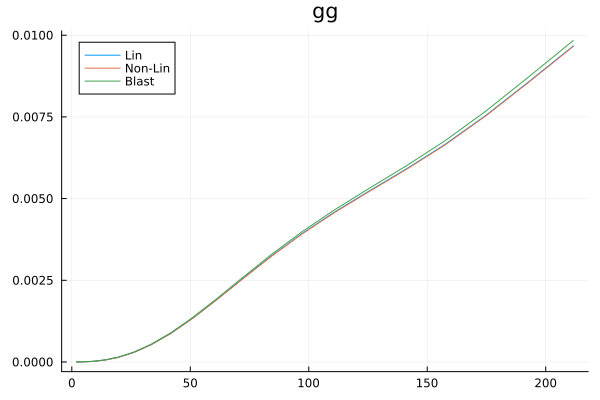

In [113]:
plot(Blast.ℓ, lin_gg, title="gg", label="Lin")
plot!(Blast.ℓ, nonlin_gg, label ="Non-Lin")
plot!(Blast.ℓ, blast_gg, label ="Blast")

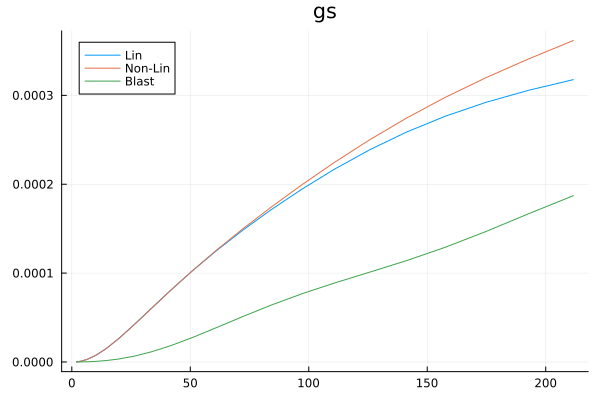

In [112]:
plot(Blast.ℓ, lin_gs, title="gs", label="Lin")
plot!(Blast.ℓ, nonlin_gs, label ="Non-Lin")
plot!(Blast.ℓ, blast_gs, label ="Blast")

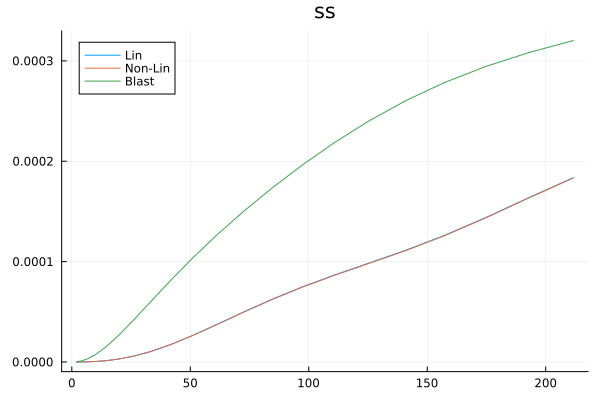

In [111]:
plot(Blast.ℓ, lin_ss, title="ss", label="Lin")
plot!(Blast.ℓ, nonlin_ss, label ="Non-Lin")
plot!(Blast.ℓ, blast_ss, label ="Blast")

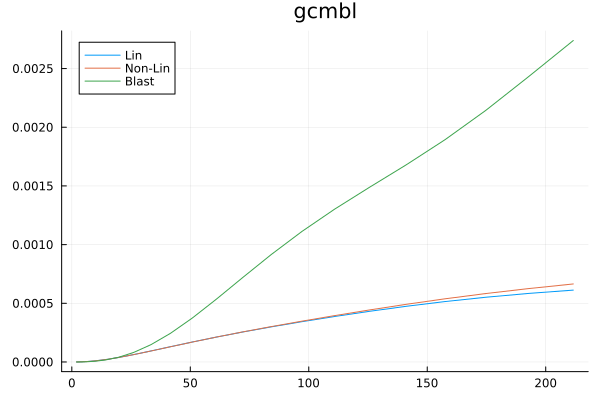

In [114]:
plot(Blast.ℓ, lin_gcmbl, title="gcmbl", label="Lin")
plot!(Blast.ℓ, nonlin_gcmbl, label ="Non-Lin")
plot!(Blast.ℓ, blast_gcmbl, label ="Blast")

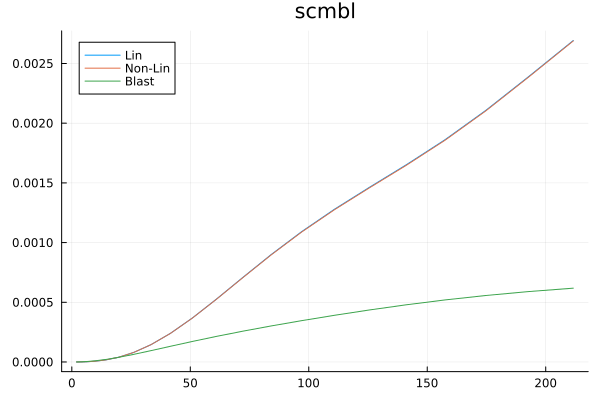

In [115]:
plot(Blast.ℓ, lin_scmbl, title="scmbl", label="Lin")
plot!(Blast.ℓ, nonlin_scmbl, label ="Non-Lin")
plot!(Blast.ℓ, blast_scmbl, label ="Blast")

In [104]:
final_Dℓ_gg = blast_gg .+ nonlin_gg .- lin_gg
final_Dℓ_gs = blast_gs .+ nonlin_gs .- lin_gs
final_Dℓ_ss = blast_ss .+ nonlin_ss .- lin_ss
final_Dℓ_gcmbl = blast_gcmbl .+ nonlin_gcmbl .- lin_gcmbl
final_Dℓ_scmbl = blast_scmbl .+ nonlin_scmbl .- lin_scmbl;

In [105]:
npzwrite("blast_cls/D_gg.npy", final_Dℓ_gg)
npzwrite("blast_cls/D_gs.npy", final_Dℓ_gs)
npzwrite("blast_cls/D_ss.npy", final_Dℓ_ss)
npzwrite("blast_cls/D_gcmbl.npy", final_Dℓ_gcmbl)
npzwrite("blast_cls/D_scmbl.npy", final_Dℓ_scmbl)

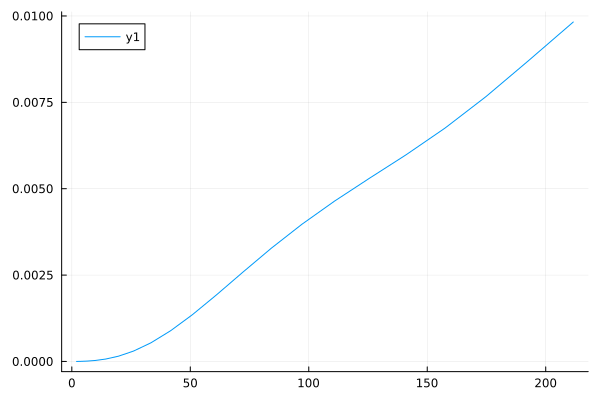

In [106]:
plot(ℓ, final_Dℓ_gg)